In [ ]:
from shapely.geometry import Polygon,Point
from shapely import affinity
from math import tan,pi,cos,sin,sqrt
import matplotlib.pyplot as plt
from ase.io import lammpsdata
import ase.atoms as atoms
import numpy as np
import sys
import ase.build as build

In [ ]:
def inside(pos,cuts):
    p=Point(pos[0],pos[1])
    for shape in cuts:
        if(not shape.contains(p)):
            return True
    return False

Cell([176.58991804787814, 127.4418203098613, 20.0])


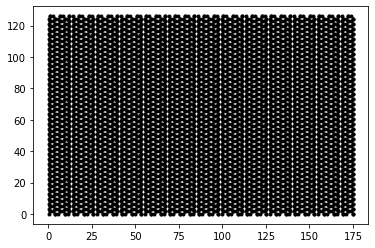

In [ ]:
lmp_in_file_name = "./POSCAR.lmp"  # do not change this
HP = 0 #float(sys.argv[2])
sx = 32 #int(sys.argv[3])   # supercell along x factor
sy = 40 # int(sys.argv[4])   # supercell along y factor
lmp_out_file_name = "./POSCAR-cut-90deg.lmp" # sys.argv[7]

np.random.seed(1)  # To reproduce the results

H_S_bl = 1.4  # Hydrogen-Sulfer bond length

lmp_data = lammpsdata.read_lammps_data(lmp_in_file_name,
                                       style="charge",
                                       units="real")

lmp_data = lmp_data*(sx, sy, 1)


atomic_positions = lmp_data.get_positions()
atomic_numbers = lmp_data.get_atomic_numbers()

S_positions = atomic_positions[np.where(atomic_numbers == 2)[0]]

S_no = S_positions.shape[0]  # Total number of Sulfer atoms

H_no = int(S_no*HP/100)  # We obtain the integer number

H_no_top = H_no//2
H_no_bot = H_no - H_no_top

S_positions_top = S_positions[S_positions[:, 2] > 10]
S_positions_bot = S_positions[S_positions[:, 2] < 10]

top_indicies = np.random.choice(
    S_positions_top.shape[0], H_no_top, replace=False)
bot_indicies = np.random.choice(
    S_positions_bot.shape[0], H_no_bot, replace=False)

# Now we are ready to add Hydrogen
for i in top_indicies:
    # Since if we specify H here then it will confuse with the atom type 1
    lmp_data.append("Li")
    lmp_data.positions[-1] = S_positions_top[i]+np.array([0, 0, H_S_bl])
for i in bot_indicies:
    lmp_data.append("Li")
    lmp_data.positions[-1] = S_positions_bot[i]+np.array([0, 0, -H_S_bl])
print(lmp_data.cell)
plt.plot(lmp_data.get_positions()[:,0],lmp_data.get_positions()[:,1],".k")
# plt.savefig("plot.svg")

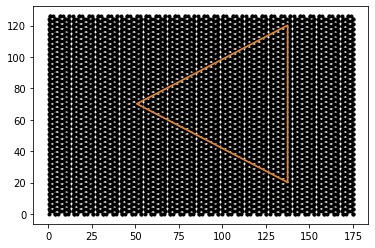

In [4]:
lx = lmp_data.cell[0,0]/2
ly = lmp_data.cell[1,1]/2
# t = lx*0.1
# lxp= lx - t
# lyp= ly - t

# tt = 2*t*0.3  # Fraction of t to cover while cutting
# theta = 20 # deg
# deg = pi/180.0
# a = (lx - t * (1 + tan(theta*deg))) * cos(theta*deg) - t;
# print(a/lx)
scale=100
triangle = Polygon(([0, 0], [1, 0], [0.5,sqrt(3)/2]))
triangle = affinity.scale(triangle,scale,scale,origin=(0,0,0))
triangle = affinity.translate(triangle,lx/2,ly/2-5)
triangle = affinity.rotate(triangle,90)
plt.plot(lmp_data.get_positions()[:,0],lmp_data.get_positions()[:,1],".k")
plt.plot(*triangle.exterior.xy)
plt.plot(*triangle.exterior.xy)
all_cuts=[triangle]

Cell([176.58991804787814, 127.4418203098613, 20.0])
Cell([102.7838754004341, 115.58580980335701, 23.187507035345014])


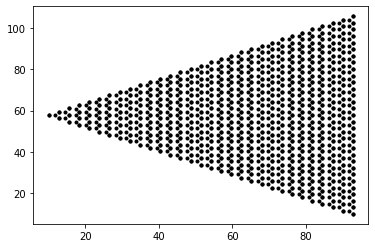

In [5]:
lmp_data.set_initial_charges(lmp_data.get_initial_charges()*0.0)
lammpsdata.write_lammps_data("./POSCAR-uncut.lmp", lmp_data, atom_style="charge")
lmp_data_cut:atoms =lmp_data.copy()
del lmp_data_cut[[atom.index for atom in lmp_data_cut if inside(atom.position,all_cuts)]]
atomic_positions=lmp_data_cut.get_positions()
xbounds=[np.min(atomic_positions[:,0]),np.max(atomic_positions[:,1])]
ybounds=[np.min(atomic_positions[:,1]),np.max(atomic_positions[:,1])]
print(lmp_data_cut.cell)
# plt.plot(lmp_data_cut.get_positions()[:,0],lmp_data_cut.get_positions()[:,1],".k")

lmp_data_cut.center(10)
print(lmp_data_cut.cell)

plt.plot(lmp_data_cut.get_positions()[:,0],lmp_data_cut.get_positions()[:,1],".k")

lammpsdata.write_lammps_data(lmp_out_file_name, lmp_data_cut, atom_style="charge")
data = open(lmp_out_file_name, "r+").readlines()
data[0] = f"Pristine 2H-MoS2 plus {HP}% Hydrogen\n"
open(lmp_out_file_name, "w").writelines(data)



In [6]:
def inside2(pos,cuts):
    p=Point(pos[0],pos[1])
    for shape in cuts:
        if(shape.contains(p)):
            return True
    return False

10.0 92.78387540043411 10.0 105.58580980335701
POLYGON ((9.5 57.792904901678504, 22.49038105676658 65.2929049016785, 22.49038105676658 50.292904901678504, 9.5 57.792904901678504))
POLYGON ((80.14704773426081 98.43936319395029, 93.13742879102739 105.93936319395029, 93.13742879102739 90.93936319395029, 80.14704773426081 98.43936319395029))
POLYGON ((80.14704773426081 17.146446609406727, 93.13742879102739 24.646446609406727, 93.13742879102739 9.646446609406727, 80.14704773426081 17.146446609406727))


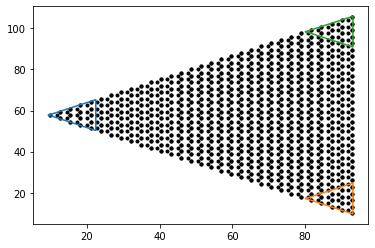

In [17]:
size = 15
shift=0.5
poss=lmp_data_cut.get_positions()
atomic_nos=lmp_data_cut.get_atomic_numbers()
xmin = np.min(poss[:,0])
xmax = np.max(poss[:,0])
ymin = np.min(poss[:,1])
ymax = np.max(poss[:,1])

print(xmin,xmax,ymin,ymax)
tri =Polygon(([0,0],[size*sqrt(3)/2,size/2],[size*sqrt(3)/2,-size/2]))
left = affinity.translate(tri,xmin-shift,(ymin+ymax)/2)
down = affinity.translate(tri,xmax-size*sqrt(3)/2+shift*sqrt(2)/2,-shift/sqrt(2)+ymin+size/2)
up = affinity.translate(tri,xmax-size*sqrt(3)/2+shift*sqrt(2)/2,+shift/sqrt(2)+ymax-size/2)

plt.plot(lmp_data_cut.get_positions()[:,0],lmp_data_cut.get_positions()[:,1],".k")
plt.plot(*left.exterior.xy)
plt.plot(*down.exterior.xy)
plt.plot(*up.exterior.xy)
all_cuts=[left,up,down]
for i in all_cuts:
    print(i)
for i in range(len(atomic_nos)):
    if(atomic_nos[i] == 1 and inside2(poss[i,:],all_cuts)):
            atomic_nos[i]=3
    elif(atomic_nos[i] == 2 and inside2(poss[i,:],all_cuts)):
            atomic_nos[i]=4
lmp_data_cut_new=lmp_data_cut.copy()
# lmp_data_cut_new.set_atomic_numbers(atomic_nos)
lammpsdata.write_lammps_data("temp.lmp", lmp_data_cut_new, atom_style="charge")
